In [1]:
#Преамбула
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

%matplotlib notebook

# Решение задачи сложной подгонки

В этом блокноте предпринята попытка решения следующей задачи.

В результате физического эксперимента были получены несколько файлов с данными по распределению температуры в пассивной части исследуемой пластины при разных значениях силы тока. Была предложена модель теплообмена с внешней средой, из которой было получено теоретической распределение температуры в пластине:
\begin{equation}\label{solve_in}
T = A e^{\beta x} + B e^{-\beta x} + \tau
\end{equation},
где наибольший интерес представляет коэффициент $\beta$, характеризующий пластину и окружающую среду.
$\tau$ по смыслу отвечает за "рабочую" температуру среды.
### Проблема

Заключалась в чрезмерно большом поле свободных параметров для подгонки, при очень маленьком числе точек(~20).

### Возможное решение

* Построить функцию на интересующим коэффициенте $\beta$, которая была бы нормой результата подгонки по оставшимся параметрам для каждой выборки.
* Произвести минимизацию функции по корректному диапозону


Для подгонки необходи передать функцию в терминах python, так что объявим её как функцию для каждого $\beta$

In [2]:
## для каждой беты своя функция
def fit_b(b):
    def func(x, a_1, a_2, t_out):
        return a_1*np.exp(b*x) + a_2*np.exp(-b*x) + t_out
    return func

#### Основная функция

Функция получает на вход кортеж данных, текущую функцию подгонки, имя файла для ведения лога, диапозон значений для подгонки.
Далее производится процедура подгонки и запись в файл оптимальных коэффициентов и их относительные погрешности(при необходимости).
Возвращается норма текущей подгонки.


In [3]:
def podgon_and(data_lol, funct, name='testing_fit', rang=(-np.inf, np.inf),log=0):
    try:
        popt, pcov = curve_fit(funct, data_lol[0], data_lol[1], bounds=rang)
        perr = np.sqrt(np.diag(pcov))
        mod = perr/popt
    except RuntimeError:
         mod = np.inf
    if (log == 1) and (np.linalg.norm(mod) < 10000):
        f = open(name, 'a')
        f.write(np.array2string(popt, separator='\t', prefix='optium')  +'\t' + np.array2string(mod, separator = '\t', prefix='error') + '\n')
        f.close()
    
    return(np.linalg.norm(mod)**2)
                                           

#### Процедура извлечения данных эксперимента.


In [4]:
list_hot=[]
for i in range(17):
    d_in = np.loadtxt(f"profil_0_{i}.txt",  dtype=np.float)
    list_hot.append((np.arange(len(d_in)), d_in))

## Построение функции от $\beta$ и данных

In [5]:
def main_fit(b, data_full,record=0):
    f_now = fit_b(b)
    namem = f"fit_b_{b}"
    mass = 0
    for data in data_full:
        mass += podgon_and(data, f_now, namem, log=record)
    return np.sqrt(mass)

### Визуальная оценка

In [32]:
x = np.arange(0.005, 0.6, 0.0001)
y = [main_fit(_, list_hot) for _ in x]

<IPython.core.display.Javascript object>


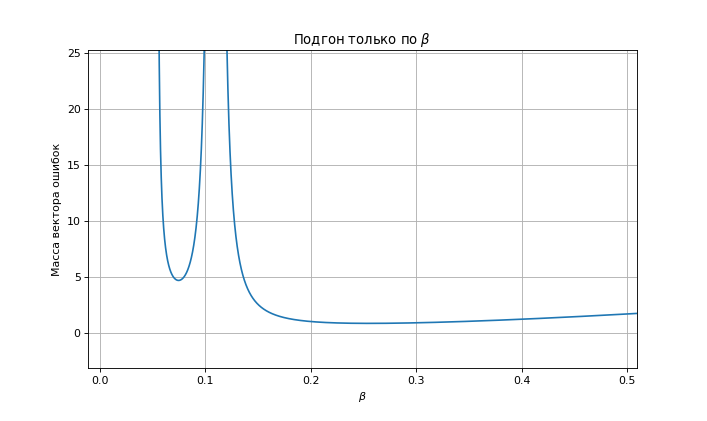

In [246]:
fig = plt.figure()
plt.plot(x, y)
plt.title('Подгон только по '+ r'$\beta $')
plt.ylabel('Масса вектора ошибок')
plt.xlabel(r'$\beta$')
plt.grid(True)

## Запуск минимизации средствами Scimpy

In [6]:
#определение функции для оптимизации
def func_to_b(b):
    return(main_fit(b, list_hot))

In [250]:
## Минимизация первой ямы
x0 = [0.05]
res = minimize(func_to_b, x0, method='Nelder-Mead',options={'xtol': 1e-7, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 4.681366
         Iterations: 22
         Function evaluations: 50
[0.07482178]


In [251]:
x0 = [0.3]
res = minimize(func_to_b, x0, method='Nelder-Mead',options={'xtol': 1e-7, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.837267
         Iterations: 22
         Function evaluations: 50
[0.25549095]


In [254]:
### Подстановка различных значений для получения лога
b_ = float(input())
res = main_fit(b_,list_hot, record=1)
print(f'Масса в локальном оптиуме =  {res}')

0.07482178
Масса в локальном оптиуме =  4.68142391199281


In [255]:
### Подстановка различных значений для получения лога
b_ = float(input())
res = main_fit(b_,list_hot, record=1)
print(f'Масса в локальном оптиуме =  {res}')

0.25549095
Масса в локальном оптиуме =  0.8372677032941243


### Подгон в границах по температуре среды

Поэтому поступим немного иначе: физически ограничим температуру подгонки и повысим её вес

Организуем принудительно подгонку в границах для температуры

In [256]:
# функция для подгонки с обрезанным диапозоном температуры
def fit_cut_t(b, data_full,record=0,t=100):
    f_now = fit_b(b)
    namem = f"fit_cut_t_{t}_b_{b}"
    mass = 0
    rang = ([-np.inf, -np.inf, 20], [np.inf, np.inf, t])
    for data in data_full:
        mass += podgon_and(data, f_now, namem,rang, log=record)
    return mass

In [257]:
y_cut =[fit_cut_t(_, list_hot, t=40) for _ in x] # получение точек то тем же x

<IPython.core.display.Javascript object>


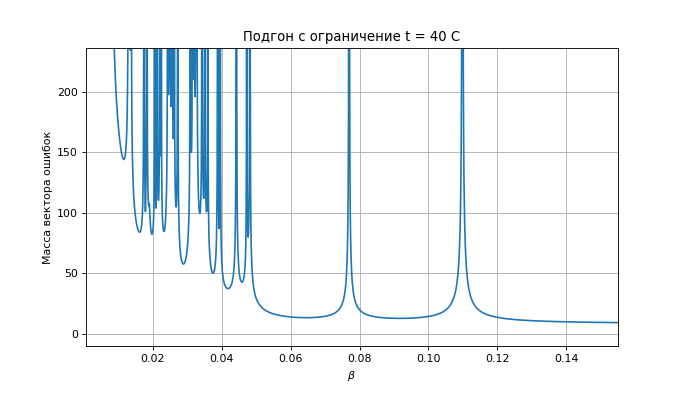

In [74]:
fig = plt.figure()
plt.plot(x, y_cut)
plt.title('Подгон с ограничение t = 40 C')
plt.ylabel('Масса вектора ошибок')
plt.xlabel(r'T_{out},C')
plt.grid(True)

In [53]:
b_ = float(input())
res = fit_cut_t(b_,list_hot, record=1,t=50)

0.06


Простая срезка не помогла, температура подгонки просто упирается в предел.
#### Пути debug'а
* поменять вес для подгонтки по температуре
* смотреть 2d распределение

# Модель постоянной температуры среды

In [6]:
#Объявление функции
def func_to_fit_t(t_):
    def func(x, a_1, a_2, b):
        return a_1*np.exp(b*x) + a_2*np.exp(-b*x) + t_
    return func

In [7]:
def fit_t(t, data_full, record=0):
    f_now = func_to_fit_t(t)
    namem = f"fit_t_{t}"
    mass = 0
    
    for data in data_full:
        mass += podgon_and(data, f_now, namem, log=record)
    return np.sqrt(mass)

#### Визуально

In [15]:
t = np.arange(20, 50 , 0.01)
k = [fit_t(_, list_hot) for _ in t]

<IPython.core.display.Javascript object>


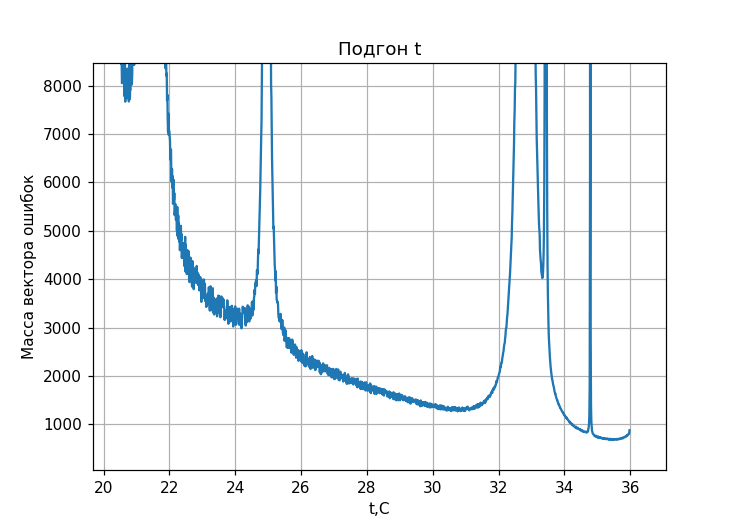

In [19]:
fig = plt.figure()
plt.plot(t, k)
plt.title('Подгон t')
plt.ylabel('Масса вектора ошибок')
plt.xlabel(r't,C')
plt.grid(True)

## Минимизация по t

In [9]:
#определение функции для оптимизации
def func_to_t(t):
    return fit_t(t, list_hot)

In [21]:
t0 = 33
res = minimize(func_to_t, t0, method='Nelder-Mead',options={'xtol': 1e-7, 'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 689.879030
         Iterations: 51
         Function evaluations: 128
[35.68125157]


#### Как видно из картинки, получилась совсем не глаткая зависимость связано это со сложнастями при подгонке таких функция как экспонента

In [37]:
### Подстановка различных значений для получения лога
t = float(input())

res = fit_t(t, list_hot, record=1)

print(f'Масса в локальном оптиуме =  {res}')


35.5
Масса в локальном оптиуме =  26.2957851701939


## Модель постоянных $T_{out}$ и $\beta$

In [109]:
# строим функцию
def func_to_fit_both(v):
    def func(x, a_1, a_2):
        return a_1*np.exp(v[0]*x) + a_2*np.exp(-v[0]*x) + v[1]
    return func

In [110]:
# основа
def fit_both (b_t, data_full, record=0):
    f_now = func_to_fit_both(b_t)
    #namem = f"fit_t_{b_t[0]}_{b_t[1]}"
    mass = 0
    for data in data_full:
        mass += podgon_and(data, f_now, log=record)
    return mass

In [12]:
def func_to_Z(b_t):
    return fit_both(b_t, list_hot)

In [112]:
# получение точек
b = np.arange(0.15, 0.25, 0.001)
t = np.arange(25, 100, 1)
Z,k = np.meshgrid(b, t)
B, T = np.meshgrid(b, t)

In [113]:
# обсчёт
for bi in b:
    i = 0
    for tau in t:
        j=0
        a = func_to_Z((bi, tau))
        if (a < 1.0):
            Z[i][j] = a
        else:
            Z[i][j] = 1
        j+=1
    i+=1

<IPython.core.display.Javascript object>


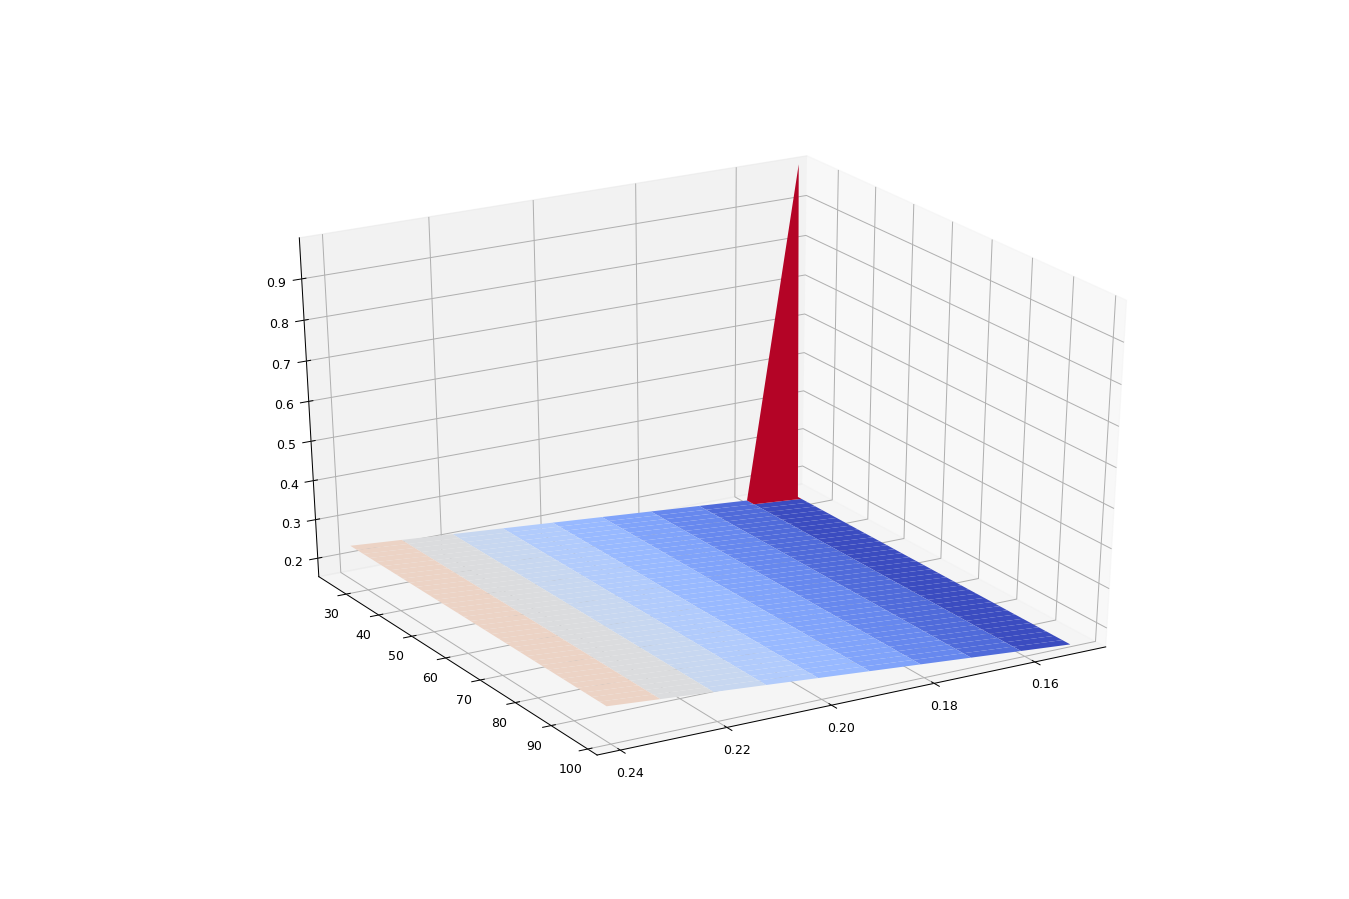

In [103]:
# Построение графика
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook
# Настраиваем 3D график
fig = plt.figure(figsize=[15, 10])
ax = fig.gca(projection='3d')

# Задаем угол обзора
ax.view_init(45, 30)

# Рисуем поверхность
surf = ax.plot_surface(B, T, Z, cmap=cm.coolwarm)
plt.show()

В общем всего, что хотелось бы достичь не удалось, ну и ладно.

![alt-текст](https://hsto.org/webt/_i/vd/cj/_ivdcjv0itamifffxs0i1i-mqh4.jpeg "Кривые, да")